In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import random

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

from genesis.visualization import *
from genesis.generator import *
from genesis.predictor import *
from genesis.optimizer import *

from definitions.generator.aparent_deconv_conv_generator_concat_trainmode import load_generator_network
from definitions.predictor.aparent import load_saved_predictor

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

from scipy.stats import norm

from genesis.vae import *

def set_seed(seed_value) :
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    os.environ['PYTHONHASHSEED']=str(seed_value)

    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    random.seed(seed_value)

    # 3. Set the `numpy` pseudo-random generator at a fixed value
    np.random.seed(seed_value)

    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    tf.set_random_seed(seed_value)

    # 5. Configure a new global `tensorflow` session
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    K.set_session(sess)

def load_data(data_name, valid_set_size=0.05, test_set_size=0.05, batch_size=32) :
    
    #Load cached dataframe
    cached_dict = pickle.load(open(data_name, 'rb'))
    plasmid_df = cached_dict['plasmid_df']
    plasmid_cuts = cached_dict['plasmid_cuts']

    #print("len(plasmid_df) = " + str(len(plasmid_df)) + " (loaded)")

    #Generate training and test set indexes
    plasmid_index = np.arange(len(plasmid_df), dtype=np.int)

    plasmid_train_index = plasmid_index[:-int(len(plasmid_df) * (valid_set_size + test_set_size))]
    plasmid_valid_index = plasmid_index[plasmid_train_index.shape[0]:-int(len(plasmid_df) * test_set_size)]
    plasmid_test_index = plasmid_index[plasmid_train_index.shape[0] + plasmid_valid_index.shape[0]:]

    #print('Training set size = ' + str(plasmid_train_index.shape[0]))
    #print('Validation set size = ' + str(plasmid_valid_index.shape[0]))
    #print('Test set size = ' + str(plasmid_test_index.shape[0]))


    data_gens = {
        gen_id : iso.DataGenerator(
            idx,
            {'df' : plasmid_df},
            batch_size=batch_size,
            inputs = [
                {
                    'id' : 'seq',
                    'source_type' : 'dataframe',
                    'source' : 'df',
                    'extractor' : lambda row, index: row['padded_seq'][180 + 40: 180 + 40 + 81] + "G" * (128-81),
                    'encoder' : iso.OneHotEncoder(seq_length=128),
                    'dim' : (1, 128, 4),
                    'sparsify' : False
                }
            ],
            outputs = [
                {
                    'id' : 'dummy_output',
                    'source_type' : 'zeros',
                    'dim' : (1,),
                    'sparsify' : False
                }
            ],
            randomizers = [],
            shuffle = True if gen_id == 'train' else False
        ) for gen_id, idx in [('all', plasmid_index), ('train', plasmid_train_index), ('valid', plasmid_valid_index), ('test', plasmid_test_index)]
    }

    x_train = np.concatenate([data_gens['train'][i][0][0] for i in range(len(data_gens['train']))], axis=0)
    x_test = np.concatenate([data_gens['test'][i][0][0] for i in range(len(data_gens['test']))], axis=0)
    
    return x_train, x_test


Using TensorFlow backend.


In [2]:
#Specfiy problem-specific parameters

experiment_suffix = '_weak_vae_very_high_kl_epoch_35_margin_0_harder_kl_penalty'

vae_model_prefix = "vae/saved_models/vae_apa_max_isoform_doubledope_weak_cano_pas_len_128_50_epochs_very_high_kl_2"
vae_model_suffix = "_epoch_35"#""#

#VAE model path
saved_vae_encoder_model_path = vae_model_prefix + "_encoder" + vae_model_suffix + ".h5"
saved_vae_decoder_model_path = vae_model_prefix + "_decoder" + vae_model_suffix + ".h5"

#Padding for the VAE
vae_upstream_padding = ''
vae_downstream_padding = 'G' * 47

#VAE sequence template
vae_sequence_template = 'ATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCC' + 'G' * (128 - 81)

#VAE latent dim
vae_latent_dim = 100

#Oracle predictor model path
saved_predictor_model_path = '../../../aparent/saved_models/aparent_plasmid_iso_cut_distalpas_all_libs_no_sampleweights_sgd.h5'

#Subtring indices for VAE
vae_pwm_start = 40
vae_pwm_end = 121

#VAE parameter collection
vae_params = [
    saved_vae_encoder_model_path,
    saved_vae_decoder_model_path,
    vae_upstream_padding,
    vae_downstream_padding,
    vae_latent_dim,
    vae_pwm_start,
    vae_pwm_end
]

#Load data set
vae_data_path = "vae/apa_doubledope_cached_set_weak_short_cano_pas.pickle"

_, x_test = load_data(vae_data_path, valid_set_size=0.005, test_set_size=0.095)


mean log(likelihood) = -39.27178970788167


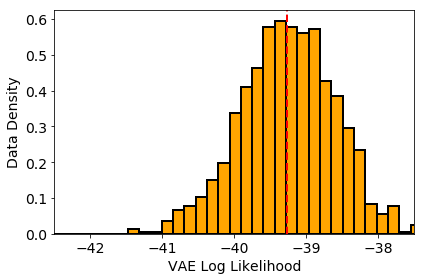

In [3]:
#Evaluate ELBO distribution on test set

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=128)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = -42.5
plot_max_val = -37.5

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


mean log(likelihood) = -39.36700169739712


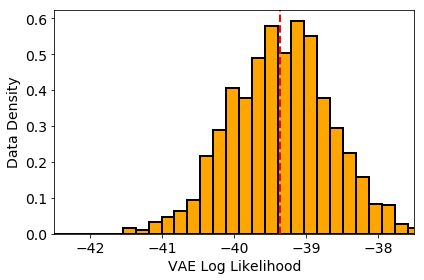

In [4]:
#Evaluate ELBO distribution on test set (training-level no. of samples)

#Load VAE models
vae_encoder_model = load_model(saved_vae_encoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})
vae_decoder_model = load_model(saved_vae_decoder_model_path, custom_objects={'st_sampled_softmax':st_sampled_softmax, 'st_hardmax_softmax':st_hardmax_softmax, 'min_pred':min_pred, 'InstanceNormalization':InstanceNormalization})

#Compute multi-sample ELBO on test set
log_mean_p_vae_test, mean_log_p_vae_test, log_p_vae_test = evaluate_elbo(vae_encoder_model, vae_decoder_model, x_test, n_samples=32)

print("mean log(likelihood) = " + str(mean_log_p_vae_test))

#Log Likelihood Plot
plot_min_val = -42.5
plot_max_val = -37.5

f = plt.figure(figsize=(6, 4))

log_p_vae_test_hist, log_p_vae_test_edges = np.histogram(log_mean_p_vae_test, bins=50, density=True)
bin_width_test = log_p_vae_test_edges[1] - log_p_vae_test_edges[0]

plt.bar(log_p_vae_test_edges[1:] - bin_width_test/2., log_p_vae_test_hist, width=bin_width_test, linewidth=2, edgecolor='black', color='orange')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

if plot_min_val is not None and plot_max_val is not None :
    plt.xlim(plot_min_val, plot_max_val)

plt.xlabel("VAE Log Likelihood", fontsize=14)
plt.ylabel("Data Density", fontsize=14)

plt.axvline(x=mean_log_p_vae_test, linewidth=2, color='red', linestyle="--")

plt.tight_layout()
plt.show()


In [3]:

#Define target isoform loss function
def get_isoform_loss(target_isos, fitness_weight=2., batch_size=32, n_samples=1, n_z_samples=1, mini_batch_size=1, seq_length=205, vae_loss_mode='bound', vae_divergence_weight=1., ref_vae_log_p=-10, vae_log_p_margin=1, decoded_pwm_epsilon=10**-6, pwm_start=0, pwm_end=70, pwm_target_bits=1.8, vae_pwm_start=0, entropy_weight=0.0, entropy_loss_mode='margin', similarity_weight=0.0, similarity_margin=0.5) :
    
    target_iso = np.zeros((len(target_isos), 1))
    for i, t_iso in enumerate(target_isos) :
        target_iso[i, 0] = t_iso
    
    masked_entropy_mse = get_target_entropy_sme_masked(pwm_start=pwm_start, pwm_end=pwm_end, target_bits=pwm_target_bits)
    if entropy_loss_mode == 'margin' :
        masked_entropy_mse = get_margin_entropy_ame_masked(pwm_start=pwm_start, pwm_end=pwm_end, min_bits=pwm_target_bits)
    
    pwm_sample_entropy_func = get_pwm_margin_sample_entropy_masked(pwm_start=pwm_start, pwm_end=pwm_end, margin=similarity_margin, shift_1_nt=True)
    
    def loss_func(loss_tensors) :
        _, _, _, sequence_class, pwm_logits_1, pwm_logits_2, pwm_1, pwm_2, sampled_pwm_1, sampled_pwm_2, mask, sampled_mask, iso_pred, cut_pred, iso_score_pred, cut_score_pred, vae_pwm_1, vae_sampled_pwm_1, z_mean_1, z_log_var_1, z_1, decoded_pwm_1 = loss_tensors
        
        #Create target isoform with sample axis
        iso_targets = K.constant(target_iso)
        iso_true = K.gather(iso_targets, sequence_class[:, 0])
        iso_true = K.tile(K.expand_dims(iso_true, axis=-1), (1, K.shape(sampled_pwm_1)[1], 1))

        #Re-create iso_pred from cut_pred
        #iso_pred = K.expand_dims(K.sum(cut_pred[..., 76:76+35], axis=-1), axis=-1)
        
        #Specify costs
        iso_loss = fitness_weight * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=1)
        
        #Construct VAE sequence inputs
        decoded_pwm_1 = K.clip(decoded_pwm_1, decoded_pwm_epsilon, 1. - decoded_pwm_epsilon)
        
        log_p_x_given_z_1 = K.sum(K.sum(vae_sampled_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...] * K.log(K.stop_gradient(decoded_pwm_1[:, :, :, pwm_start-vae_pwm_start:pwm_end-vae_pwm_start, ...])) / K.log(K.constant(10.)), axis=(-1, -2)), axis=-1)
        
        log_p_std_normal_1 = K.sum(normal_log_prob(z_1, 0., 1.) / K.log(K.constant(10.)), axis=-1)
        log_p_importance_1 = K.sum(normal_log_prob(z_1, z_mean_1, K.sqrt(K.exp(z_log_var_1))) / K.log(K.constant(10.)), axis=-1)
        
        log_p_vae_1 = log_p_x_given_z_1 + log_p_std_normal_1 - log_p_importance_1
        log_p_vae_div_n_1 = log_p_vae_1 - K.log(K.constant(n_z_samples, dtype='float32')) / K.log(K.constant(10.))

        #Calculate mean ELBO across samples (log-sum-exp trick)
        max_log_p_vae_1 = K.max(log_p_vae_div_n_1, axis=-1)

        log_mean_p_vae_1 = max_log_p_vae_1 + K.log(K.sum(10**(log_p_vae_div_n_1 - K.expand_dims(max_log_p_vae_1, axis=-1)), axis=-1)) / K.log(K.constant(10.))
        
        #Specify VAE divergence loss function
        vae_divergence_loss = 0.
        
        if vae_loss_mode == 'bound' :
            vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(log_mean_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -log_mean_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(log_mean_p_vae_1)), axis=1)
        
        elif vae_loss_mode == 'penalty' :
            vae_divergence_loss = vae_divergence_weight * K.mean(-log_mean_p_vae_1, axis=1)
        
        elif vae_loss_mode == 'target' :
            vae_divergence_loss = vae_divergence_weight * K.mean((log_mean_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        elif 'mini_batch_' in vae_loss_mode :
            mini_batch_log_mean_p_vae_1 = K.permute_dimensions(K.reshape(log_mean_p_vae_1, (int(batch_size / mini_batch_size), mini_batch_size, n_samples)), (0, 2, 1))
            mini_batch_mean_log_p_vae_1 = K.mean(mini_batch_log_mean_p_vae_1, axis=-1)
            tiled_mini_batch_mean_log_p_vae_1 = K.tile(mini_batch_mean_log_p_vae_1, (mini_batch_size, 1))
            
            if vae_loss_mode == 'mini_batch_bound' :
                vae_divergence_loss = vae_divergence_weight * K.mean(K.switch(tiled_mini_batch_mean_log_p_vae_1 < ref_vae_log_p - vae_log_p_margin, -tiled_mini_batch_mean_log_p_vae_1 + (ref_vae_log_p - vae_log_p_margin), K.zeros_like(tiled_mini_batch_mean_log_p_vae_1)), axis=1)
            elif vae_loss_mode == 'mini_batch_target' :
                vae_divergence_loss = vae_divergence_weight * K.mean((tiled_mini_batch_mean_log_p_vae_1 - (ref_vae_log_p - vae_log_p_margin))**2, axis=1)
        
        entropy_loss = entropy_weight * masked_entropy_mse(pwm_1, mask)
        entropy_loss += similarity_weight * K.mean(pwm_sample_entropy_func(sampled_pwm_1, sampled_pwm_2, sampled_mask), axis=1)
        
        #Compute total loss
        total_loss = iso_loss + entropy_loss + vae_divergence_loss
        
        return total_loss
    
    return loss_func

class EpochVariableCallback(Callback):
    def __init__(self, my_variable, my_func):
        self.my_variable = my_variable       
        self.my_func = my_func
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))

#Function for running GENESIS
def run_genesis(sequence_templates, loss_func, library_contexts, model_path, batch_size=32, n_samples=1, n_z_samples=1, vae_params=None, n_epochs=10, steps_per_epoch=100) :
    
    #Build Generator Network
    _, generator = build_generator(batch_size, len(sequence_templates[0]), load_generator_network, n_classes=len(sequence_templates), n_samples=n_samples, sequence_templates=sequence_templates, batch_normalize_pwm=False)

    #Build Predictor Network and hook it on the generator PWM output tensor
    _, sample_predictor = build_predictor(generator, load_saved_predictor(model_path, library_contexts=library_contexts), batch_size, n_samples=n_samples, eval_mode='sample')

    #Build VAE model
    vae_tensors = []
    if vae_params is not None :
        encoder_model_path, decoder_model_path, vae_upstream_padding, vae_downstream_padding, vae_latent_dim, vae_pwm_start, vae_pwm_end = vae_params
        vae_tensors = build_vae(generator, encoder_model_path, decoder_model_path, batch_size=batch_size, seq_length=len(sequence_templates[0]), n_samples=n_samples, n_z_samples=n_z_samples, vae_latent_dim=vae_latent_dim, vae_upstream_padding=vae_upstream_padding, vae_downstream_padding=vae_downstream_padding, vae_pwm_start=vae_pwm_start, vae_pwm_end=vae_pwm_end)

    #Build Loss Model (In: Generator seed, Out: Loss function)
    _, loss_model = build_loss_model(sample_predictor, loss_func, extra_loss_tensors=vae_tensors)
    
    #Specify Optimizer to use
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

    #Compile Loss Model (Minimize self)
    loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

    #Fit Loss Model
    train_history = loss_model.fit(
        [], np.ones((1, 1)),
        epochs=n_epochs,
        steps_per_epoch=steps_per_epoch
    )

    return generator, sample_predictor, train_history


In [4]:
#Maximize isoform proportion

sequence_templates = [
    'CTTCCGATCTCTCGCTCTTTCTATGGCATTCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
]

library_contexts = [
    'doubledope'
]

margin_similarities = [
    0.5
]


In [5]:
#Generate new random seed
print(np.random.randint(low=0, high=1000000))

343312


In [ ]:
#Train APA Cleavage GENESIS Network

print("Training GENESIS")

#Number of PWMs to generate per objective
batch_size = 64
mini_batch_size = 8
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of VAE latent vector samples  at each grad step
n_z_samples = 32#128#32
#Number of epochs per objective to optimize
n_epochs = 50#10#5#25
#Number of steps (grad updates) per epoch
steps_per_epoch = 50

seed = 104590

for class_i in range(len(sequence_templates)) :
    lib_name = library_contexts[class_i].split("_")[0]
    print("Library context = " + str(lib_name))
    
    K.clear_session()
    
    set_seed(seed)
    
    loss = get_isoform_loss(
        [1.0],
        fitness_weight=1.0,#0.5,
        batch_size=batch_size,
        n_samples=n_samples,
        n_z_samples=n_z_samples,
        mini_batch_size=mini_batch_size,
        seq_length=len(sequence_templates[0]),
        vae_loss_mode='mini_batch_bound',#'target',
        vae_divergence_weight=40.0 * 1./71.,#5.0 * 1./71.,#0.5 * 1./71.,
        ref_vae_log_p=-39.367,
        vae_log_p_margin=0.0,
        #decoded_pwm_epsilon=0.05,
        pwm_start=vae_pwm_start + 5,
        pwm_end=vae_pwm_start + 5 + 71,
        vae_pwm_start=vae_pwm_start,
        pwm_target_bits=1.8,
        entropy_weight=0.5,#0.01,
        entropy_loss_mode='margin',
        similarity_weight=5.0,#0.5,#5.0,
        similarity_margin=margin_similarities[class_i]
    )

    genesis_generator, genesis_predictor, train_history = run_genesis([sequence_templates[class_i]], loss, [library_contexts[class_i]], saved_predictor_model_path, batch_size, n_samples, n_z_samples, vae_params, n_epochs, steps_per_epoch)

    genesis_generator.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_generator.get_layer('lambda_rand_input_2').function = lambda inp: inp

    genesis_predictor.get_layer('lambda_rand_sequence_class').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_1').function = lambda inp: inp
    genesis_predictor.get_layer('lambda_rand_input_2').function = lambda inp: inp

    # Save model and weights
    save_dir = 'saved_models'

    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    
    model_name = 'genesis_apa_max_isoform_' + str(lib_name) + experiment_suffix + '_vae_kl_generator.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_generator.save(model_path)
    print('Saved trained model at %s ' % model_path)

    model_name = 'genesis_apa_max_isoform_' + str(lib_name) + experiment_suffix + '_vae_kl_predictor.h5'
    model_path = os.path.join(save_dir, model_name)
    genesis_predictor.save(model_path)
    print('Saved trained model at %s ' % model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


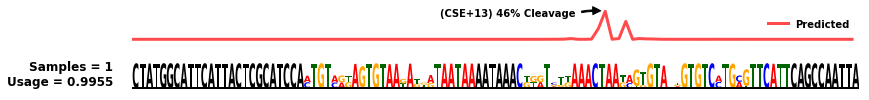

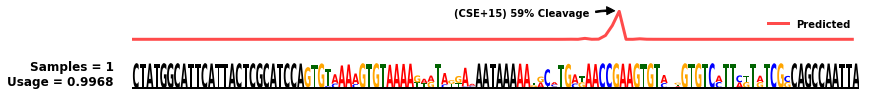

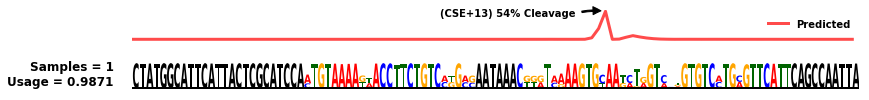

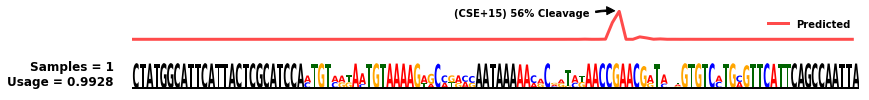

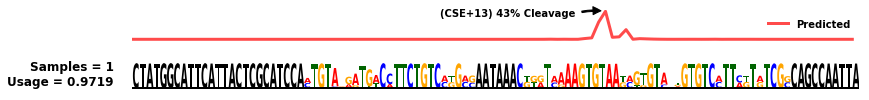

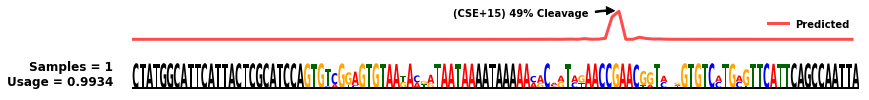

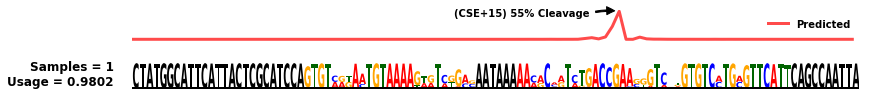

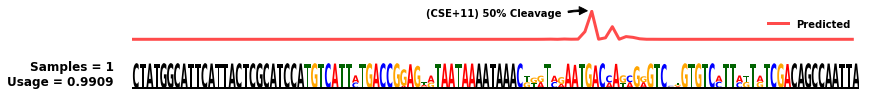

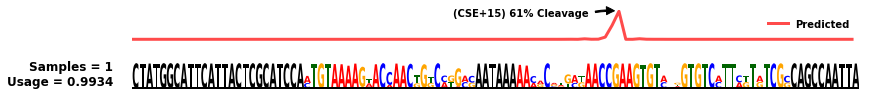

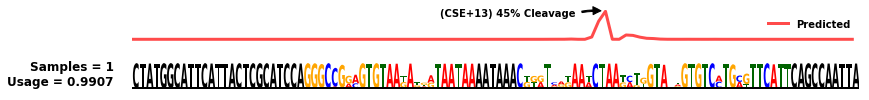

In [6]:
#Load GENESIS models and predict sample sequences

lib_name = library_contexts[0].split("_")[0]
batch_size = 64

model_names = [
    'genesis_apa_max_isoform_' + str(lib_name) + experiment_suffix + '_vae_kl',
]

sequence_templates = [
    'CTTCCGATCTCTCGCTCTTTCTATGGCATTCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
]

for class_i in range(len(sequence_templates)-1, 0-1, -1) :
    
    save_dir = os.path.join(os.getcwd(), 'saved_models')
    model_name = model_names[class_i] + '_predictor.h5'
    model_path = os.path.join(save_dir, model_name)

    predictor = load_model(model_path, custom_objects={'st_sampled_softmax': st_sampled_softmax, 'st_hardmax_softmax': st_hardmax_softmax})
    
    n = batch_size

    sequence_class = np.array([0] * n).reshape(-1, 1) #np.random.uniform(-6, 6, (n, 1)) #

    noise_1 = np.random.uniform(-1, 1, (n, 100))
    noise_2 = np.random.uniform(-1, 1, (n, 100))

    pred_outputs = predictor.predict([sequence_class, noise_1, noise_2], batch_size=batch_size)

    _, _, _, optimized_pwm, _, _, _, _, _, iso_pred, cut_pred, _, _ = pred_outputs
    
    #Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

    for pwm_index in range(10) :

        sequence_template = sequence_templates[class_i]

        pwm = np.expand_dims(optimized_pwm[pwm_index, :, :, 0], axis=0)
        cut = np.expand_dims(cut_pred[pwm_index, 0, :], axis=0)
        iso = np.expand_dims(np.sum(cut[:, 80: 115], axis=-1), axis=-1)

        plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(12, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-50, plot_end=76+50, save_figs=True, fig_name='genesis_apa_max_isoform_' + str(lib_name) + experiment_suffix + "_pwm_index_" + str(pwm_index), fig_dpi=150)
